In [1]:
"""
# Local FinBERT Training – News Client

Client: Financial News  
Task: 3-class Sentiment Classification (Negative / Neutral / Positive)  
Model: ProsusAI FinBERT  
Federated Role: Local Client Training (Non-IID)
"""

'\n# Local FinBERT Training – News Client\n\nClient: Financial News  \nTask: 3-class Sentiment Classification (Negative / Neutral / Positive)  \nModel: ProsusAI FinBERT  \nFederated Role: Local Client Training (Non-IID)\n'

In [2]:
#All the Imports
import pandas as pd
import numpy as np
import torch

from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
#Loadig News Dataset
news = pd.read_csv("data/processed/news.csv")

print(news.head())
print(news["label"].value_counts())

                                                text  label
0  "according to gran , the company has no plans ...      1
1  "technopolis plans to develop in stages an are...      1
2  "the international electronic industry company...      0
3  with the new production plant the company woul...      2
4  "according to the company 's updated strategy ...      2
label
1    2879
2    1363
0     604
Name: count, dtype: int64


In [5]:
#Train Test Validate Split
X = news["text"]
y = news["label"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

X_val, _, y_val, _ = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))

print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation label distribution:")
print(y_val.value_counts(normalize=True))

Train size: 3392
Validation size: 727

Train label distribution:
label
1    0.594045
2    0.281250
0    0.124705
Name: proportion, dtype: float64

Validation label distribution:
label
1    0.594223
2    0.281981
0    0.123796
Name: proportion, dtype: float64


In [7]:
#Loading the Model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=3
)

model.to(device)
print("FinBERT loaded successfully on:", device)

FinBERT loaded successfully on: cuda


In [8]:
#Dataset Class
class FinSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [9]:
#Dataset Class Objects and Dataset Loader
train_dataset = FinSentimentDataset(X_train, y_train, tokenizer)
val_dataset   = FinSentimentDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Dataset and DataLoader created successfully")

Dataset and DataLoader created successfully


In [10]:
#Optimizer and Loss
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
#Local Training
epochs = 3

model.train()
for epoch in range(epochs):
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:39<00:00,  5.42it/s]


Epoch 1/3 - Loss: 0.7530


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:39<00:00,  5.40it/s]


Epoch 2/3 - Loss: 0.2914


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [00:39<00:00,  5.39it/s]

Epoch 3/3 - Loss: 0.1373


In [12]:
#Validation Evaluation
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [13]:
#Metrics Computation
accuracy = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average="weighted"
)

print(f"Validation Accuracy : {accuracy:.4f}")
print(f"Precision           : {precision:.4f}")
print(f"Recall              : {recall:.4f}")
print(f"F1-score            : {f1:.4f}")

Validation Accuracy : 0.8239
Precision           : 0.8418
Recall              : 0.8239
F1-score            : 0.8267


In [14]:
#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 76   7   7]
 [ 22 342  68]
 [  3  21 181]]


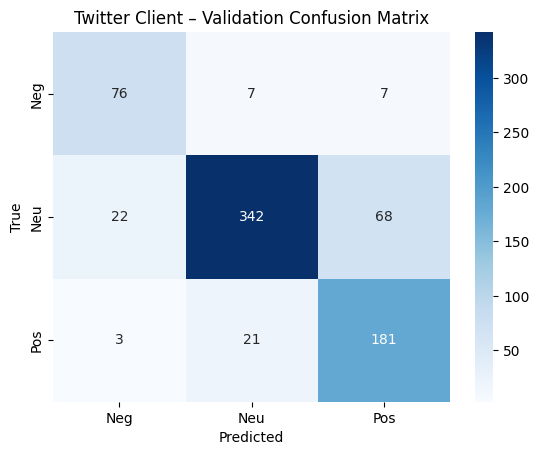

In [15]:
#Heatmap of Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg", "Neu", "Pos"],
            yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Twitter Client – Validation Confusion Matrix")
plt.show()

In [16]:
import os

save_path = "models/news_local_finbert"
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('models/news_local_finbert\\tokenizer_config.json',
 'models/news_local_finbert\\special_tokens_map.json',
 'models/news_local_finbert\\vocab.txt',
 'models/news_local_finbert\\added_tokens.json',
 'models/news_local_finbert\\tokenizer.json')

In [17]:
#Checking if Tokenizer Loads
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("models/news_local_finbert")
print("Tokenizer loaded successfully")

Tokenizer loaded successfully


In [7]:
# Saving News validation split
X_val.to_csv("data/splits/news_val_text.csv", index=False)
y_val.to_csv("data/splits/news_val_labels.csv", index=False)

print("News validation split saved")


News validation split saved
